In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
import matplotlib.pyplot as plt
import time
import os
import glob

In [2]:
# Nessa versão estamos aplicando uma técnica chamada 'Data Interleaving'
# Estaremos intercalando os dados
# Em vez de pegar os primeiros 90% (que é só Machado) e testar nos 10% (que é só SAC)
# vamos criar pedaços aleatórios.
# Dividir em blocos aleatórios para garantir mistura de domínios
# Mas como estamos num modelo simples de sequencia, o jeito mais fácil e seguro
# para manter a coerência do texto é garantir que o split seja feito DEPOIS de misturar 
# O texto gerado será um Frankenstein, entretanto agora ele irá aprender a gramática correta dos textos
# Além disso aumentamos as configurações, pois estamos usando uma RX 5600 (6GB VRAM) e 16GB de RAM DDR4 3200mhz para os testes
# Então aumentamos o poder de processamento da nossa LLM

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Rodando no dispositivo: {device}")

Rodando no dispositivo: cpu


In [4]:
# Otimizadas para RX 5600 (6GB VRAM)
block_size = 256      # AUMENTO: De 64 para 256. (Lê parágrafos inteiros agora)
batch_size = 32       # AUMENTO: De 16 para 32.
max_iters = 5000      # Mantém
learning_rate = 3e-4  # Mantém
eval_iters = 200
n_embd = 256          # De 128 para 256. (Vetores mais ricos para o vocabulário BPE)
n_layer = 6           # AUMENTO: De 4 para 6. (Mais profundidade de raciocínio)
n_head = 8            # AUMENTO: De 4 para 8. (Tem que ser divisor de n_embd: 256 / 8 = 32)
dropout = 0.2         # Mantém para evitar overfitting

In [5]:
# Pega TODOS os arquivos .txt da pasta data/
files = glob.glob('data/*.txt')
print(f"Encontrados {len(files)} arquivos para treinamento.")

# Palavras para banir
blacklist = [
    "Página", "Page", 
    "Colleen Hoover", "Machado de Assis", 
    "Sumário", "Capítulo", "Copyright", 
    "Todos os direitos reservados"
]

all_text_content = "" # Vamos acumular tudo numa string gigante

for file_name in files:
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            raw_text = f.read()
            
            # FASE DE LIMPEZA
            clean_lines = []
            lines = raw_text.split('\n')
            
            for line in lines:
                line = line.strip()
                
                # Filtros de Lixo (Números de página, linhas vazias)
                if not line: continue
                if line.isdigit(): continue # Remove "12", "45"
                
                # Filtro de Blacklist (Cabeçalhos repetidos)
                if any(bad_word in line for bad_word in blacklist):
                    continue
                
                # Filtro de tamanho (Evita linhas com 1 letra que não sejam pontuação)
                if len(line) < 2 and line not in ['.', '?', '!', '—']:
                    continue

                clean_lines.append(line)
            
            # Juntar as linhas limpas deste livro
            book_text = "\n".join(clean_lines)
            
            # Adicionar ao texto total com o marcador especial
            # O marcador <|endoftext|> avisa o modelo que a história acabou
            all_text_content += book_text + " <|endoftext|> \n"
            
            print(f" - Processado: {file_name} ({len(clean_lines)} linhas úteis)")

    except Exception as e:
        print(f"Erro ao ler {file_name}: {e}")

text = all_text_content
print(f"Dataset FINAL criado com {len(text)/1e6:.2f} MB de texto.")

Encontrados 13 arquivos para treinamento.
 - Processado: data/constituicao_federal.txt (3575 linhas úteis)
 - Processado: data/verity.txt (3258 linhas úteis)
 - Processado: data/uma_segunda_chance.txt (5064 linhas úteis)
 - Processado: data/se_nao_fosse_voce.txt (5781 linhas úteis)
 - Processado: data/um_caso_perdido.txt (3299 linhas úteis)
 - Processado: data/lado_feio_do_amor.txt (4490 linhas úteis)
 - Processado: data/assim_que_acaba.txt (4626 linhas úteis)
 - Processado: data/dom_casmurro.txt (6804 linhas úteis)
 - Processado: data/assim_que_comeca.txt (4650 linhas úteis)
 - Processado: data/talvez_nao_colleen_hoover.txt (1321 linhas úteis)
 - Processado: data/memorias_postumas.txt (6475 linhas úteis)
 - Processado: data/todas_as_suas_imperfeicoes.txt (3486 linhas úteis)
 - Processado: data/sem_esperancas.txt (8156 linhas úteis)
Dataset FINAL criado com 6.20 MB de texto.


In [6]:
# TOKENIZAÇÃO TIKTOKEN
print("Tokenizando com GPT-2 BPE")
enc = tiktoken.get_encoding("gpt2")
encoded_data = enc.encode(text, allowed_special={"<|endoftext|>"})
vocab_size = enc.n_vocab # Isso será 50257 (Padrão GPT-2)
print(f"Tamanho do Vocabulário: {vocab_size} tokens únicos")
print(f"Total de Tokens para treino: {len(encoded_data)}")

Tokenizando com GPT-2 BPE
Tamanho do Vocabulário: 50257 tokens únicos
Total de Tokens para treino: 2506590


In [7]:
# Em vez de pegar os primeiros 90% (que é só Machado) e testar nos 10% (que é só SAC),
# vamos criar pedaços aleatórios.
data = torch.tensor(encoded_data, dtype=torch.long)

# Dividir em blocos aleatórios para garantir mistura de domínios
# Mas como estamos num modelo simples de sequencia, o jeito mais fácil e seguro
# para manter a coerência do texto é garantir que o split seja feito DEPOIS de misturar 
# se tivéssemos amostras independentes.
# Como é um texto contínuo, vamos fazer o seguinte:

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [8]:
# Infraestrutura do Modelo Transformer
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_metrics():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)

        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()

            probs = F.softmax(logits, dim=-1)
            pred = torch.argmax(probs, dim=-1)
            acc = (pred == Y.view(-1)).float().mean()
            accuracies[k] = acc.item()

        out[split] = {
            'loss': losses.mean(),
            'acc': accuracies.mean()
        }
    model.train()
    return out

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   
        q = self.query(x) 
        wei = q @ k.transpose(-2, -1) * C**-0.5 
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v 
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
        
class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Anteriormente no gpt-v3 o vocab_size era 95 vocab_size agora é 50257
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index) 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) 
        x = tok_emb + pos_emb
        x = self.blocks(x) 
        x = self.ln_f(x) 
        logits = self.lm_head(x) 

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
            idx = torch.cat((idx, idx_next), dim=1) 
        return idx

In [9]:
# Execução e Checkpointing
def save_checkpoint(step, model, optimizer, loss_train, loss_val, acc_train, acc_val, filename="checkpoint_gpt_v5.pth"):
    checkpoint = {
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_train': loss_train,
        'loss_val': loss_val,
        'acc_train': acc_train,
        'acc_val': acc_val
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint salvo em step {step}")

def load_checkpoint(model, optimizer, filename="checkpoint_gpt_v5.pth"):
    if os.path.exists(filename):
        print(f"Carregando checkpoint '{filename}'...")
        checkpoint = torch.load(filename, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        step = checkpoint['step']
        loss_train = checkpoint.get('loss_train', [])
        loss_val = checkpoint.get('loss_val', [])

        acc_train = checkpoint.get('acc_train', []) 
        acc_val = checkpoint.get('acc_val', [])

        print(f"Retomando do step {step}")
        return step, loss_train, loss_val, acc_train, acc_val
    return 0, [], [], [], []

model = GPTLanguageModel()
m = model.to(device)
print(f"Modelo PT-BR criado com {sum(p.numel() for p in m.parameters())/1e6:.2f} M parâmetros")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Tenta carregar checkpoint
start_iter, loss_history_train, loss_history_val, acc_history_train, acc_history_val = load_checkpoint(model, optimizer)

print("Iniciando treinamento em Português...")
start_time = time.time()

for iter in range(start_iter, max_iters):
    
    if iter % eval_iters == 0:
        metrics = estimate_metrics()

        t_loss, v_loss = metrics['train']['loss'], metrics['val']['loss']
        t_acc, v_acc = metrics['train']['acc'], metrics['val']['acc']

        print(f"step {iter}: loss {t_loss:.3f}/{v_loss:.3f} | acc {t_acc:.3f}/{v_acc:.3f}")

        # Atualiza históricos
        loss_history_train.append(t_loss)
        loss_history_val.append(v_loss)
        acc_history_train.append(t_acc)
        acc_history_val.append(v_acc)
        
        # Salvar checkpoint
        save_checkpoint(iter, model, optimizer, 
                        loss_history_train, loss_history_val, 
                        acc_history_train, acc_history_val)

    # Backpropagation padrão
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

end_time = time.time()
print(f"Treinamento finalizado em {(end_time - start_time)/60:.2f} minutos.")

Modelo PT-BR criado com 30.58 M parâmetros
Carregando checkpoint 'checkpoint_gpt_v5.pth'...
Retomando do step 3000
Iniciando treinamento em Português...
step 3000: loss 2.483/2.358 | acc 0.465/0.456
Checkpoint salvo em step 3000
step 3200: loss 2.437/2.341 | acc 0.473/0.457
Checkpoint salvo em step 3200
step 3400: loss 2.422/2.327 | acc 0.476/0.465
Checkpoint salvo em step 3400
step 3600: loss 2.397/2.297 | acc 0.479/0.473
Checkpoint salvo em step 3600
step 3800: loss 2.354/2.291 | acc 0.487/0.469
Checkpoint salvo em step 3800
step 4000: loss 2.334/2.272 | acc 0.489/0.480
Checkpoint salvo em step 4000
step 4200: loss 2.316/2.232 | acc 0.493/0.486
Checkpoint salvo em step 4200
step 4400: loss 2.291/2.247 | acc 0.496/0.487
Checkpoint salvo em step 4400
step 4600: loss 2.269/2.234 | acc 0.500/0.487
Checkpoint salvo em step 4600
step 4800: loss 2.254/2.237 | acc 0.502/0.491
Checkpoint salvo em step 4800
Treinamento finalizado em 518.16 minutos.


Gráfico salvo: grafico_completo_metrics.png


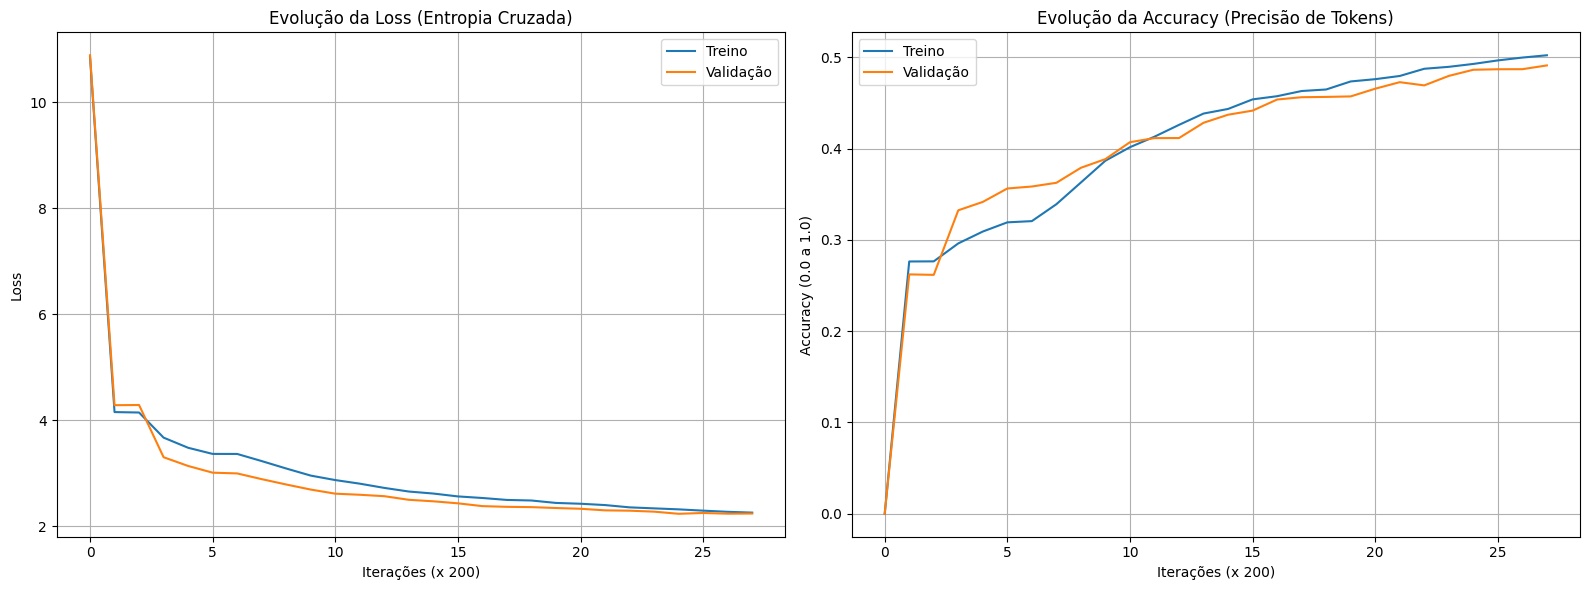

In [10]:
# Plotagem do Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Loss
ax1.plot(loss_history_train, label='Treino')
ax1.plot(loss_history_val, label='Validação')
ax1.set_title('Evolução da Loss (Entropia Cruzada)')
ax1.set_xlabel(f'Iterações (x {eval_iters})')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Gráfico 2: Accuracy
ax2.plot(acc_history_train, label='Treino')
ax2.plot(acc_history_val, label='Validação')
ax2.set_title('Evolução da Accuracy (Precisão de Tokens)')
ax2.set_xlabel(f'Iterações (x {eval_iters})')
ax2.set_ylabel('Accuracy (0.0 a 1.0)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('grafico_completo_metrics.png')
print("Gráfico salvo: grafico_completo_metrics.png")

In [11]:
# Geração de Texto
print("\n" + "="*30)
print("GERANDO TEXTO EM PORTUGUÊS")
print("="*30 + "\n")

model.eval()


GERANDO TEXTO EM PORTUGUÊS



GPTLanguageModel(
  (token_embedding_table): Embedding(50257, 256)
  (position_embedding_table): Embedding(256, 256)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=256, out_features=32, bias=False)
            (query): Linear(in_features=256, out_features=32, bias=False)
            (value): Linear(in_features=256, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_aff

In [12]:
# Gerar texto a partir do vazio
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_ids = model.generate(context, max_new_tokens=200)

# Decode usando tiktoken
print(enc.decode(generated_ids[0].tolist()))

# Salvando
torch.save(model.state_dict(), 'gpt_ptbr_v5.pth')
print("Modelo salvo como gpt_ptbr_v5.pth")

! Já então você usou você ou. Lembra que você estava com sede, e então eu desisti o quanto você se decepcionei. Especialmente seu humor me perguntar sobre o que ela está usando, eu disse que morava sozinho. Ela sabe que eu não queria que fosse um kit de fúrcum voto. Eu gosto de música.
Muito bem como se não sabia se o que conheci. Meu choro era líquido uma história.
Imagine ou talvez essa. Mas certamente como uma família esperava meu grande. Fiquei nada devastada do que a amava. Afinal, ela foi traído algo
Modelo salvo como gpt_ptbr_v5.pth
